In [239]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm, pearsonr,kendalltau,multivariate_normal, t,norm, multivariate_t,kurtosis,probplot,rankdata
import seaborn as sns
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
from copulas.bivariate import Clayton, Gumbel
from copulas.univariate import StudentTUnivariate
from copulas.multivariate import GaussianMultivariate
import statsmodels.api as sm

In [5]:
my_data=pd.read_csv(r"C:\Users\ontha\OneDrive\Desktop\UJ\Hons\Risk Measurement 1\crypto_prices.csv",sep=";")

In [9]:
my_data["LogReturns_BTC"]=np.log(my_data["BTC-USD"]/my_data["BTC-USD"].shift(1))
my_data["LogReturns_ETH"]=np.log(my_data["ETH-USD"]/my_data["ETH-USD"].shift(1))
my_data.dropna(inplace=True)
my_data

,Date,BTC-USD,ETH-USD,LogReturns_BTC,LogReturns_ETH
2,2020/01/03,7344.884277,134.171707,0.050172,0.051709
3,2020/01/04,7410.656738,135.069366,0.008915,0.006668
4,2020/01/05,7411.317383,136.276779,0.000089,0.008899
5,2020/01/06,7769.219238,144.304153,0.047161,0.057235
6,2020/01/07,8163.692383,143.543991,0.049527,-0.005282
...,...,...,...,...,...
1455,2023/12/26,42520.402344,2231.465332,-0.025374,-0.018249
1456,2023/12/27,43442.855469,2378.739990,0.021462,0.063912
1457,2023/12/28,42627.855469,2347.566162,-0.018938,-0.013192
1458,2023/12/29,42099.402344,2300.690674,-0.012474,-0.020170


Log returns are very significant in financial analysis, as they give robust framework for analysing derivative pricicng, risk modelling and building models.
1. **DERIVATIVE PRICING:** Many pricing models, like the Black-Scholes framework, rely on log returns because of their convenient mathematical properties.
2. **RISK MODELLING:** Log returns are critical in assessing volatility and calculating risk measures like Value-at-Risk (VaR).
3. **BUILDING MODELS:** Very significant in time series forecasting, portfolio optimization or machine learning models.

# **STYLIZED FACTS**

**1.** **BITCOIN**

In [15]:
mean_BTC=np.mean(my_data["LogReturns_BTC"])
std_BTC=np.std(my_data["LogReturns_BTC"])
kurt=kurtosis(my_data["LogReturns_BTC"],fisher=True)

* **HEAVY TAILS**

In [176]:
print(f"Kurtosis equal to: {kurt}")

Kurtosis equal to: 22.524576298528306


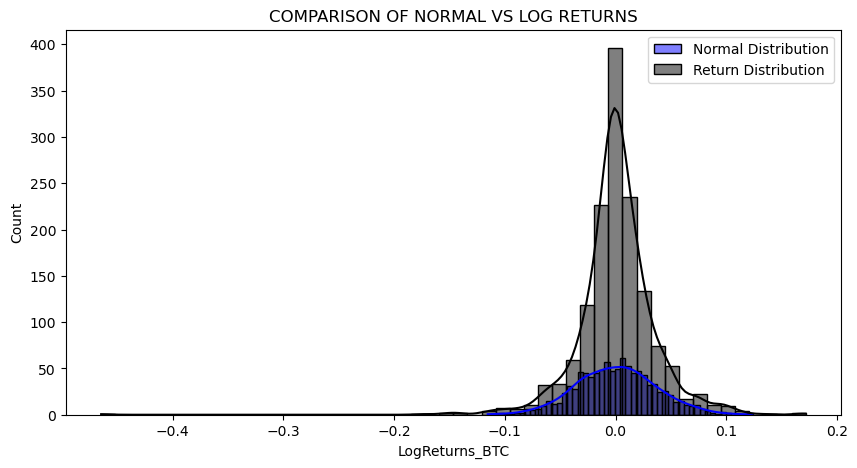

In [307]:
normal_data = np.random.normal(mean_BTC, std_BTC, 1000)
plt.figure(figsize=(10,5))
sns.histplot(normal_data, bins=50, kde=True, color="blue", label="Normal Distribution")
sns.histplot(my_data["LogReturns_BTC"],bins=50,kde=True,color="black",label="Return Distribution")
plt.legend()
plt.title("COMPARISON OF NORMAL VS LOG RETURNS")
plt.show()

* Bitcoin exhibits extreme price movements compared to a normal distribution, as evidenced by its heavy-tailed return distribution. This implies that large gains or losses occur far more frequently than what would be predicted by a normal distribution.

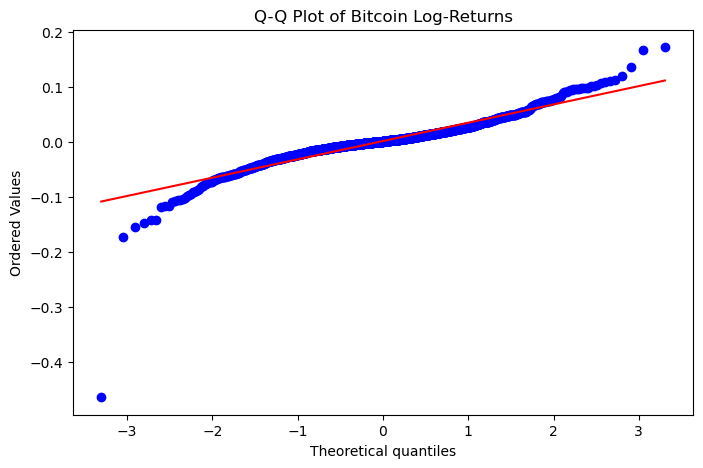

In [183]:
plt.figure(figsize=(8, 5))
probplot(my_data['LogReturns_BTC'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Bitcoin Log-Returns")
plt.show()

* This QQ plot make a strong case for the presence of heavy tails, as the points in the tails deviate sharply from the diagonal line indicating that the returns has more extreme values than the normal distribution.

* **VOLATILITY CLUSTERING**

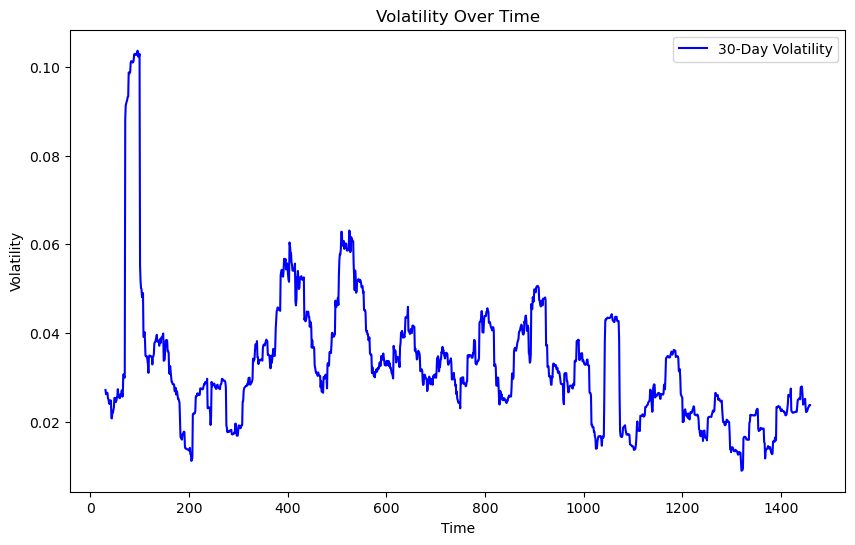

In [313]:
rolling_std = pd.Series(my_data['LogReturns_BTC']).rolling(window=30).std()

# Plot rolling volatility
plt.figure(figsize=(10, 6))
plt.plot(rolling_std, label="30-Day Volatility", color='blue')
plt.title("Volatility Over Time")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

* The returns of Bitcoin on volatility overtime time plot indicates that there is an evidence of volatility clustering. The rolling standard deviation demonstrates alternating periods of high and low volatility, with noticeable spikes followed by calmer periods.
* The GARCH model would be very efficient in capturing time-varying volatility and volatility clustering.

In [187]:
# ARCH/GARCH Model for volatility modeling
Garch_M=arch_model(my_data["LogReturns_BTC"], vol="Garch",p=1,q=1)
results=Garch_M.fit()
print(results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 65776401.01867496
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2134127.1296781623
Iteration:      3,   Func. Count:     24,   Neg. LLF: -358.2876010259555
Iteration:      4,   Func. Count:     31,   Neg. LLF: -2788.803611789367
Iteration:      5,   Func. Count:     37,   Neg. LLF: 63.28050736834357
Iteration:      6,   Func. Count:     46,   Neg. LLF: 3431501.1079322
Iteration:      7,   Func. Count:     57,   Neg. LLF: 1563.6986826494417
Iteration:      8,   Func. Count:     64,   Neg. LLF: -478.9041556424005
Iteration:      9,   Func. Count:     72,   Neg. LLF: -2208.2753453316022
Iteration:     10,   Func. Count:     79,   Neg. LLF: 23459.03218496393
Iteration:     11,   Func. Count:     87,   Neg. LLF: -1683.9811977352315
Iteration:     12,   Func. Count:     96,   Neg. LLF: 1579894.8474412279
Iteration:     13,   Func. Count:    107,   Neg. LLF: -2487.6829010016163
Iteration:     14,   Func. Count:    114,   Neg. LLF: 

C:\Users\ontha\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001259. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


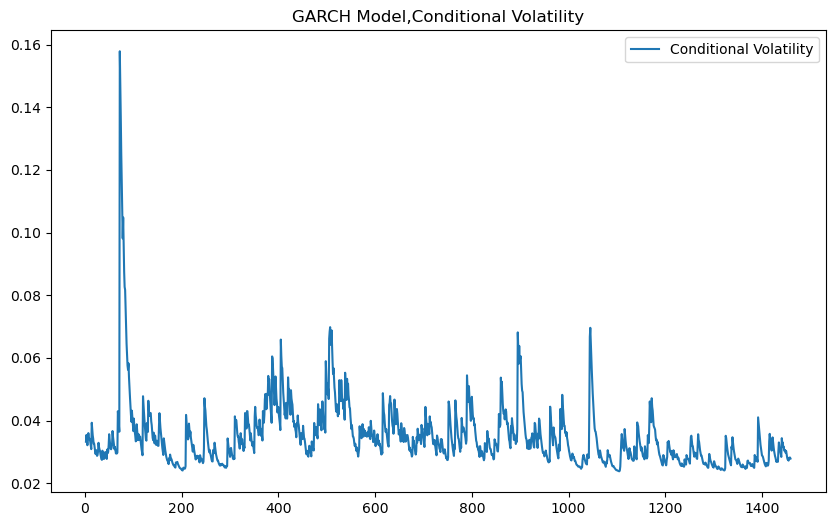

In [189]:
# Plot volatility
plt.figure(figsize=(10, 6))
plt.plot(results.conditional_volatility, label='Conditional Volatility')
plt.title('GARCH Model,Conditional Volatility')
plt.legend()
plt.show()

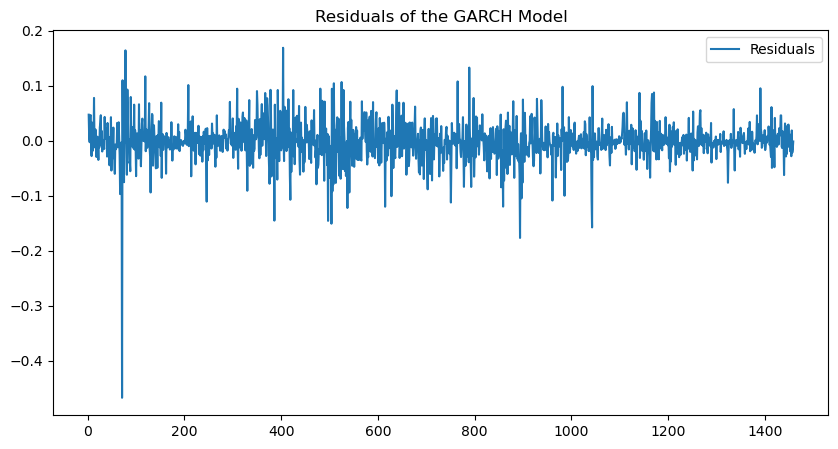

In [191]:
residuals = results.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals, label='Residuals')
plt.title("Residuals of the GARCH Model")
plt.legend()
plt.show()

1. **MODEL FIT**  The GARCH(1,1) model demonstrates high volatility persistence and exhibits strong clustering, as evidenced by the sum of alpha and beta coefficients equating to 0.9341—slightly close to 1. The model fits the data well and is supported by the high log-likelihood value and low AIC/BIC values.
2. **Conditional Volatility :** The conditional volatility reveals volatility clustering, with Bitcoin's price experiencing rapid declines followed by sustained fluctuations. This pattern highlights the market's sensitivity to shocks and the persistence of dynamic price movements.
3. **Standardised Residuals :** The residuals appear randomly scattered around the horizontal axis, suggesting the model's adequacy in capturing volatility. However, the presence of an outlier around time 50 might affect the model performance.

* **AUTOCORRELATION**

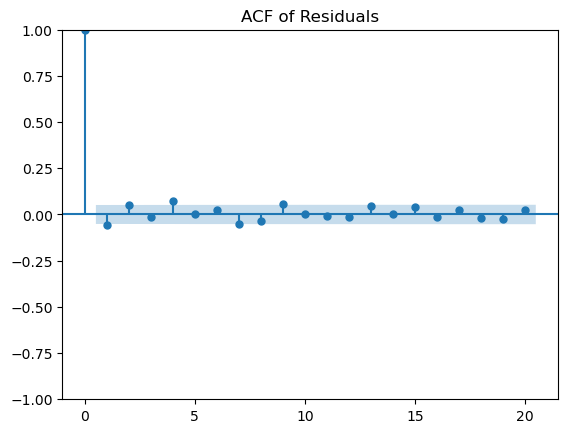

In [197]:
plot_acf(residuals, lags=20)
plt.title("ACF of Residuals")
plt.show()

In [199]:
acf_residuals = sm.tsa.acf(residuals, nlags=10, fft=True)
print("ACF of residuals:\n", acf_residuals)

ACF of residuals:
 [ 1.         -0.05512214  0.0494659  -0.01541154  0.07489781  0.00142803
  0.02401215 -0.04992305 -0.0352355   0.05435331  0.00501885]


**ACF of Residuals:**  Indicates that there is only one significance at lag 0 and at non-zero lags the autocorrelation is zero.
* The ACF residuals above indicate a very weak autocorrelation in the data.

**2.** **ETHEREUM**

In [20]:
mean_ETH=np.mean(my_data["LogReturns_ETH"])
std_ETH=np.std(my_data["LogReturns_ETH"])
kurt_ETH=kurtosis(my_data["LogReturns_ETH"],fisher=True)

* **HEAVY TAILS**

In [203]:
print(f"Excess Kurtosis of ETH equal to: {kurt_ETH}")

Excess Kurtosis of ETH equal to: 17.226872103479028


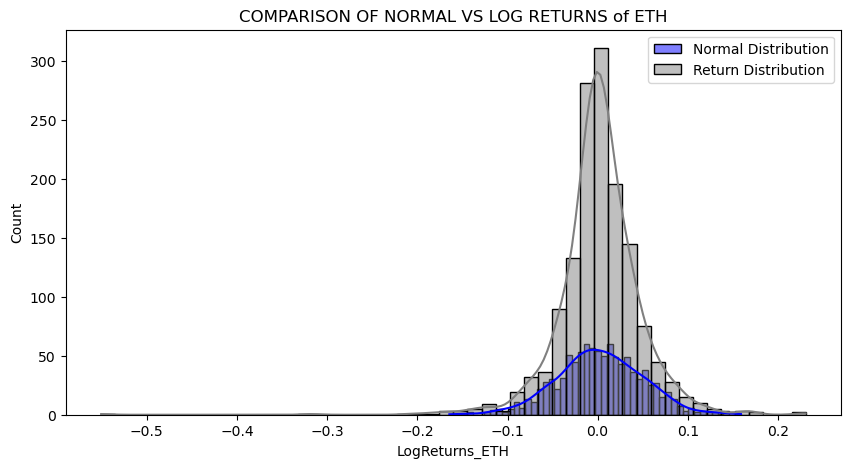

In [205]:
normal_data = np.random.normal(mean_ETH, std_ETH, 1000)
plt.figure(figsize=(10,5))
sns.histplot(normal_data, bins=50, kde=True, color="blue", label="Normal Distribution")
sns.histplot(my_data["LogReturns_ETH"],bins=50,kde=True,color="grey",label="Return Distribution")
plt.legend()
plt.title("COMPARISON OF NORMAL VS LOG RETURNS of ETH")
plt.show()

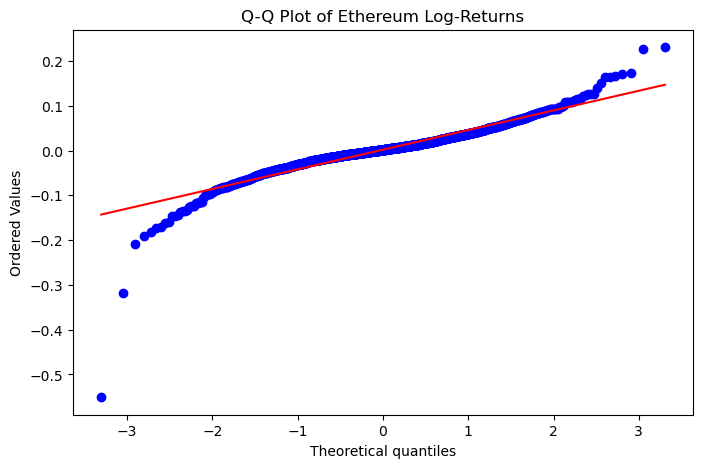

In [207]:
plt.figure(figsize=(8, 5))
probplot(my_data['LogReturns_ETH'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Ethereum Log-Returns")
plt.show()

* The Kurtosis is larger than of a normal distribution this provides strong statistical evidence of Heavy tails stylized fact and from the histogram, the ETH return distribution has shaper peaks and fatter tails than normal distribution. There is a non-Gaussian nature in the log returns as returns do not follow a bell-shaped curve compared to normal distribution.
*  The QQ plot makes a strong case for the presence of heavy tails, as the points in the tails deviate sharply from the diagonal line indicating that the returns have more extreme values than the normal distribution.

* **VOLATILITY CLUSTERING**

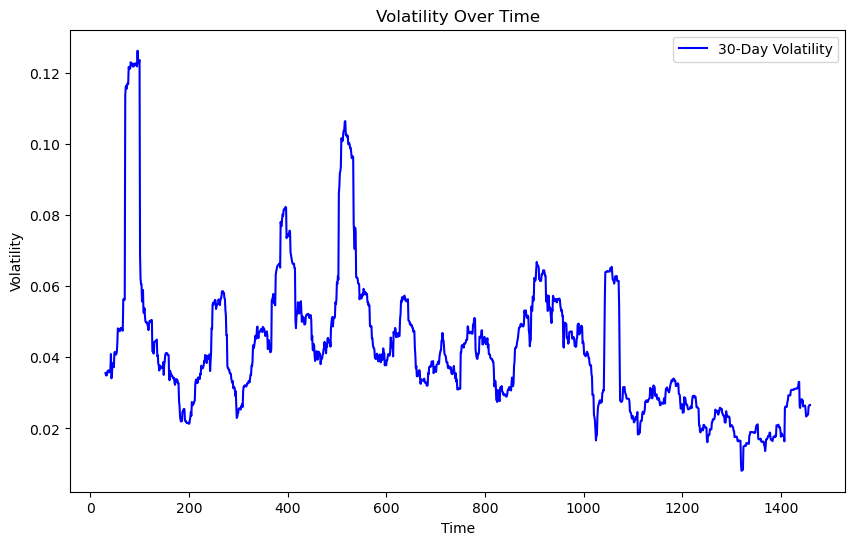

In [320]:
rolling_std = pd.Series(my_data['LogReturns_ETH']).rolling(window=30).std()

# Plot rolling volatility
plt.figure(figsize=(10, 6))
plt.plot(rolling_std, label="30-Day Volatility", color='blue')
plt.title("Volatility Over Time")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [211]:
Garch_ETF=arch_model(my_data["LogReturns_ETH"], vol="Garch",p=3,q=1)
result=Garch_ETF.fit()
print(result.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 180834.58493341404
Iteration:      2,   Func. Count:     21,   Neg. LLF: 62035.984672561324
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1609912.0329219892
Iteration:      4,   Func. Count:     47,   Neg. LLF: 36113.311635410406
Iteration:      5,   Func. Count:     61,   Neg. LLF: 2875.5280791206023
Iteration:      6,   Func. Count:     72,   Neg. LLF: 7162.9681369795935
Iteration:      7,   Func. Count:     84,   Neg. LLF: -1672.636305925666
Iteration:      8,   Func. Count:     93,   Neg. LLF: -844.1465629313029
Iteration:      9,   Func. Count:    103,   Neg. LLF: -2565.328863119569
Iteration:     10,   Func. Count:    111,   Neg. LLF: -2545.976536338888
Iteration:     11,   Func. Count:    119,   Neg. LLF: -2566.417197193028
Iteration:     12,   Func. Count:    127,   Neg. LLF: -2566.9894152992147
Iteration:     13,   Func. Count:    135,   Neg. LLF: -2566.604178981564
Iteration:     14,   Func. Count:    143,   Neg. L

C:\Users\ontha\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002149. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


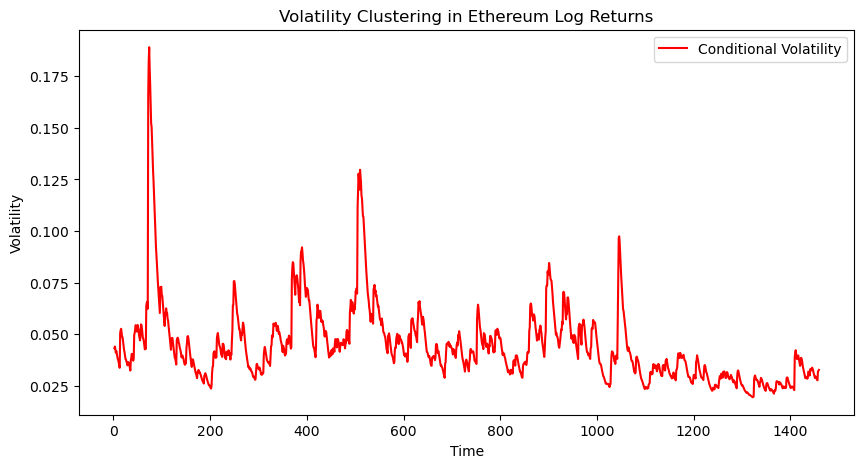

In [213]:
plt.figure(figsize=(10, 5))
plt.plot(result.conditional_volatility, label="Conditional Volatility", color="red")
plt.title("Volatility Clustering in Ethereum Log Returns")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

* At time 75, volatility rises sharply to 0.19, followed by other periods of elevated volatility, such as at time 500 when it hits 0.125. This indicates that large price movements tend to cluster together rather than occur randomly.
* Between high-volatility spikes, volatility remains low for extended periods, such as at time 200 (0.025) and time 600 (0.035). This persistence of low volatility highlights the tendency for calmer periods to cluster similarly.
* The graph fluctuates between clusters of high and low volatility, reflecting the stylized fact that markets exhibit non-random behavior where periods of intensity and calmness follow recognizable patterns.

* **AUTOCORRELATION**

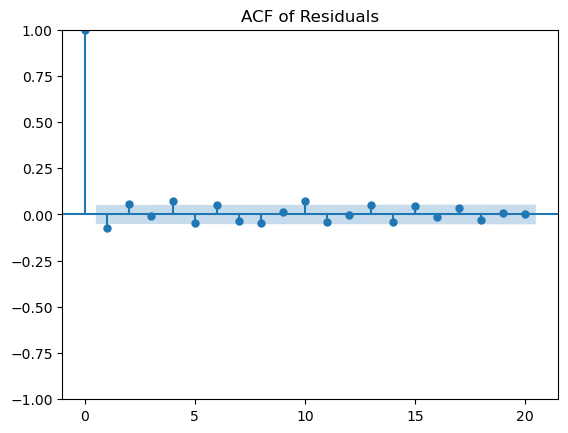

In [217]:
plot_acf(result.resid, lags=20)
plt.title("ACF of Residuals")
plt.show()

In [219]:
acf_residuals = sm.tsa.acf(result.resid, nlags=10, fft=True)
print("ACF of residuals:\n", acf_residuals)

ACF of residuals:
 [ 1.         -0.07089877  0.05405608 -0.01085521  0.07343875 -0.04860514
  0.0515841  -0.03553163 -0.04721246  0.01229466  0.07072438]


In [221]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Ljung-Box test FOR NO AUTOCRRELATION SIGNIFICACE
lb_test = acorr_ljungbox(my_data["LogReturns_ETH"], lags=[10], return_df=True)
print("Ljung-Box Test Results:\n", lb_test)

Ljung-Box Test Results:
       lb_stat  lb_pvalue
10  39.746031   0.000019


* Based on the results of the Ljung-Box test and the ACF values of the residuals shows that there is an evidence of weak autocorrelation. As the pvalue is less that the significance level, rejecting the hypothesis of No autocorrelation.

# **COPULA SELECTION**

In [83]:
#Transform observed data into uniform variables
ranks_btc=rankdata(my_data["LogReturns_BTC"])/(len(my_data["LogReturns_BTC"])+1)
ranks_eth=rankdata(my_data["LogReturns_ETH"])/(len(my_data["LogReturns_ETH"])+1)

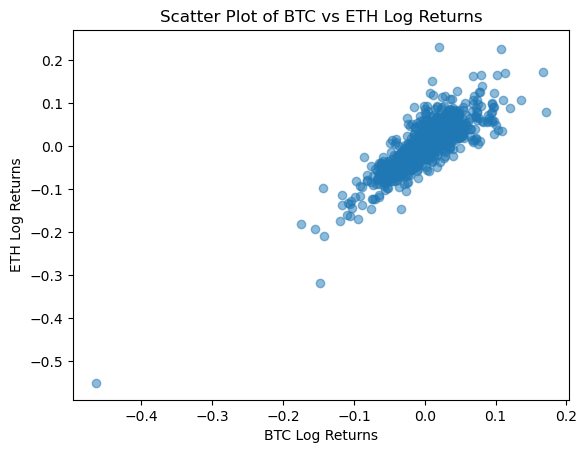

In [22]:
plt.scatter(my_data["LogReturns_BTC"], my_data["LogReturns_ETH"], alpha=0.5)
plt.title("Scatter Plot of BTC vs ETH Log Returns")
plt.xlabel("BTC Log Returns")
plt.ylabel("ETH Log Returns")
plt.show()

* Looking into the returns plot, there is evidence of a strong positive correlation between ETH and BTC. This suggests that as one increases  in value, the other is likely to follow, implying that they might move in the same direction under normal market conditions. Points are more clustered in the origin and go up as variables increase this shows that there is a weaker upper tail dependence suggesting that the two cryptocurrencies may not always experience extreme joint gains together. Similarly, the lower-tail dependence is very weak with only a few isolated extreme events like in (-0.48,-0.58). More clustering near the origin might indicate moderate co-movement in non-extreme conditions. All this downplays the use of Gumbel and Clayton copula. While the Gaussian copula captures some characteristics that reflect the data, such as moderate co-movements under normal market conditions, it falls short in capturing the unique features of cryptocurrency returns, particularly the heavy tails and clustering during high-volatility periods. from the presence of heavy tails and volatility clustering stylized facts of the two this suggests that the **student t-copula** will be able to ensure that it balances the dependency across both tails even with weaker tail dependence and might account for periods of extreme events.
* The use of statistical Measures such as Log-likelihood and AIC scores may come in handy to be able to judge which copula is appropriate to model the dependency of the two cryptocurrencies.

In [104]:
def calculate_aic(log_likelihood, n):
    return 2*n -2*log_likelihood

In [167]:
#Fit Student t copula
student_t = StudentTUnivariate()
student_t.fit(np.column_stack((ranks_btc, ranks_eth))) 
student_pdf = student_t.probability_density(np.column_stack((ranks_btc, ranks_eth))) 
log_student_t = np.sum(np.log(student_pdf))  # Calculate log-likelihood manually

#Fit guassian Copula
gaussian = GaussianMultivariate()
gaussian.fit(np.column_stack((ranks_btc, ranks_eth))) 
gaussian_pdf = gaussian.probability_density(np.column_stack((ranks_btc, ranks_eth)))  
log_gaussian = np.sum(np.log(gaussian_pdf))  

s=len(student_t.to_dict())
g=len(gaussian.to_dict())

aic_gaussian = calculate_aic(log_gaussian, g)
aic_student = calculate_aic(log_student_t, s)

print("AIC - Gaussian Copula:", aic_gaussian)
print("AIC - Student's t Copula:", aic_student)
print("Log_likelihood of gaussian:" ,log_gaussian)
print("Log_likelihood of Student:" ,log_student_t)


AIC - Gaussian Copula: 6696.73482208762
AIC - Student's t Copula: 1033.2617342420635
Log_likelihood of gaussian: -3344.36741104381
Log_likelihood of Student: -512.6308671210318


* The fact that Student's t-copula has a higher log-likelihood and lower AIC compared to the ones of Gaussian copula demonstrates that it is a better fit for modeling the dependency structure between BTC and ETH. And therefore the most appropriate copula for modeling the dependence between Bitcoin and Ethereum is **STUDENT'S T-COPULA**.

**Copula Estimation Visualization**

In [227]:
df_btc,loc_btc,scale_btc=t.fit(my_data["LogReturns_BTC"])
df_eth,loc_eth,scale_eth=t.fit(my_data["LogReturns_ETH"])
#Convert to t-distributed scores using inverse t CDF
tscores_btc=t.ppf(ranks_btc,df=df_btc)
tscores_eth=t.ppf(ranks_eth,df=df_eth)
#Estimate Empirical Correlation Matrix:
corr_matrix=np.corrcoef(tscores_btc,tscores_eth)

In [268]:
def t_copula_sample(n,df,corrmatrix):
    u=np.random.uniform(0,1,size=(n,2))
    t_space=t.ppf(u,df)
    L=np.linalg.cholesky(corr_matrix)
    
    return np.dot(t_space,L.T)
samples=t_copula_sample(1000,5,corr_matrix)
u=t.cdf(samples[:,0],5)
v=t.cdf(samples[:,1],5)
x=t.ppf(u,df=df_btc,loc=loc_btc,scale=scale_btc)
y=t.ppf(v,df=df_eth,loc=loc_eth,scale=scale_eth)

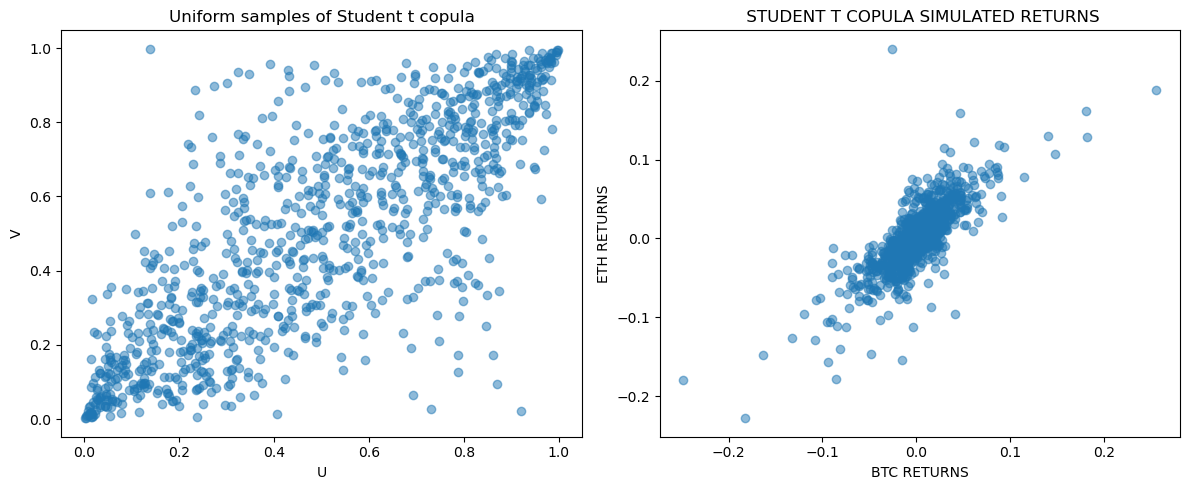

In [270]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(u,v,alpha=0.5)
ax[0].set_title("Uniform samples of Student t copula")
ax[0].set_xlabel("U")
ax[0].set_ylabel("V")

ax[1].scatter(x,y,alpha=0.5)
ax[1].set_title(" STUDENT T COPULA SIMULATED RETURNS")
ax[1].set_xlabel("BTC RETURNS")
ax[1].set_ylabel("ETH RETURNS")
plt.tight_layout()
plt.show()

**Comparison with Traditional Correlation:**

* Copula-based dependence structure focuses on modeling the joint distribution of multiple random variables separately from their individual marginal distributions. They allow flexible modeling of dependence, unlike traditional correlation measures which assume linear relationships
* Besides traditional correlation measures being simple and effective for linear dependencies, they fail to meet expectations in modeling complex, nonlinear relationships in the cryptocurrency markets. Copulas such as student's t-copula do so excellently, offering rich insights by addressing asymmetry, heavy tails, and extreme co-movement.
* Comparing uniform samples of the Student’s t-Copula with Pearson correlation samples would give solid evidence of the fundamental differences between based copula dependence structures and traditional correlation measures.
  

In [272]:
pearson_corr,_=pearsonr(samples[:,0],samples[:,1])


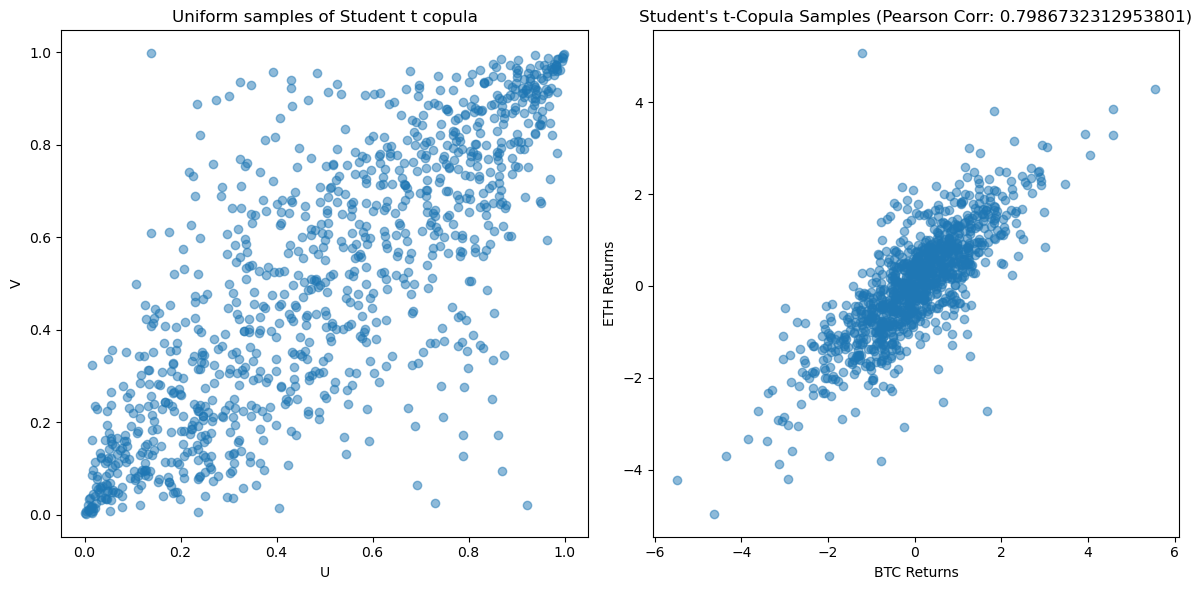

In [274]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(u,v,alpha=0.5)
ax[0].set_title("Uniform samples of Student t copula")
ax[0].set_xlabel("U")
ax[0].set_ylabel("V")
ax[1].scatter(samples[:, 0], samples[:, 1], alpha=0.5)
ax[1].set_title(f"Student's t-Copula Samples (Pearson Corr: {pearson_corr})")
ax[1].set_xlabel("BTC Returns")
ax[1].set_ylabel("ETH Returns")
plt.tight_layout()
plt.show()

**Predictability of Co-Movements**

* The Copula structure can help model the dependence between Bitcoin and Ethereum ,highlighting the potential for extreme co-movements. However the cryptocurrency markets are highly volatile ,complex and influenced by external factors such as regulatory changes ,geopolitical events , supply and demand. These factors shows that copula structure alone cannot be sufficient to predict the  future price co-movements between Bitcoin and Ethereum. While the copula based-models are useful for understanding risk dynamics and co-movements , they should be complemented with other risk assessmnet tools and various approaches to be able to predict future price co-movements. 

**Reaction to Sudden Price Increases**

* Looking into the uniform samples and simulated returns plot. The uniform sample plot reflects a strong positive dependence between U and V, suggesting that the second cryptocurrency is likely to also increase in price. However, the simulated returns plots say otherwise with more clustering of points near the origin supporting moderate co-movements. This highlights that while the copula models a strong dependency, real-world factors represented in the marginal distributions add variability, allowing for the possibility of independent price movements. Thus the second cryptocurrency might not always follow the first and when it does the probability will be very low.

**Behavior During Market Crashes**

* The uniform sample plot, which captures the copula's dependency structure, indicates consistent co-movement patterns across both tails due to the strong positive dependence. If one cryptocurrency experiences a sudden crash, the model suggests that the other is likely to follow with a decline. However, the simulated returns plot shows clustering near the origin, highlighting moderate co-movements during normal conditions. This suggests that the decline may not be as severe considering the moderate co-movements during normal conditions.

**Comparison of Joint Price Movements**

In [296]:
upper_tail=(samples[:,0]>2)&(samples[:,1]>2)
lower_tail=(samples[:,0]<-2)&(samples[:,1]<-2)
prob_jointIncrease = np.sum(upper_tail) / 1000
prob_jointCrash = np.sum(lower_tail) / 1000
print("Probability of joint price increases equal to", prob_jointIncrease)
print("Probability of joint price crashes equal to ", prob_jointCrash)

Probability of joint price increases equal to 0.023
Probability of joint price crashes equal to  0.027


* The two cryptocurrencies are more likely to crash together compared to their chances of experiencing extreme gains together based on the probabilities. So the portfolio is more exposed to joint crashes and it is therefore vulnerable to losses. It highlights the need for risk management strategies such as stress testing and diversification to protect against potential downturns.

**Investment Implications**

* Due to more expectations in the joint crash of Bitcoin and Ethereum compared to their joint gains and also with moderate co-movement in consideration. Investors may try to limit themselves from risks and protect themselves from portfolio losses while maximizing opportunities. There are several trading Strategies that investors may use, such as **hedging**, **spreads**, **Arbitrage opportunities**,  and even **Combinations** trading strategy such as straddles may be considered even when there are more risks in it when used.
  
* **HEDGING:** An investor holding Bitcoin and Ethereum can secure a forward contract by taking a short position at today's price for any cryptocurrency anticipated to crash in the near future, as indicated by the copula dependence structure. Given the moderate co-movement between Bitcoin and Ethereum, adding other assets to the portfolio could help offset potential losses from joint crashes in these two cryptocurrencies, making diversification a highly effective strategy.

* **Arbitrage:** The copula dependence structure indicates that Bitcoin and Ethereum generally move together but not perfectly. This creates arbitrage opportunities when their prices diverge from expected patterns. For example, if Ethereum's price drops faster than anticipated relative to Bitcoin, an arbitrageur can purchase Ethereum at a lower price and hold it, expecting the prices to return to their balanced relationship.

* **Spreads**: To further manage risks associated with potential crashes in cryptocurrencies, an investor could adopt a Bear Put Spread as part of a trading strategy. This involves purchasing a put option with a higher strike price while simultaneously writing another put option with a lower strike price on the same cryptocurrency.

* **Combinations:** Given that the probabilities of joint price increases and crashes are relatively close, there is significant volatility but no clear directional trend on the movement. This indicates uncertainty in the movement of cryptocurrency prices, with neither gains nor losses dominating. A straddle strategy, as a combination trading strategy, could be considered. In this strategy, an investor purchases both a put option and a call option with the same strike price and maturity. This allows the investor to capitalize on volatility, regardless of whether the price moves up or down. Although the strategy can be expensive and carries certain risks, the volatility clustering observed in the two cryptocurrencies makes it a potentially worthwhile consideration.